In [3]:
#Code for 1 and 2 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Importing and Cleaning Data

In [4]:
#Read the primary and secondary sales files
secondary_sales = pd.read_csv("WC_DS_Ex1_Sec_Sales.csv",parse_dates=[3],index_col=[3]).sort_index()
primary_sales = pd.read_csv("WC_DS_Ex1_Pri_Sales.csv",parse_dates=[3],index_col=[3]).sort_index()
invoice_record = pd.read_csv("WC_DS_EX1_Inv.csv",parse_dates=[3],index_col=[3]).sort_index()

1. Aggregate the Sales_Qty for each Store-SKU at a month level; detect any Outliers in the
Sales_Qty for each Store-SKU combination and apply an outlier treatment on the same.
Specify the outlier treatment technique.
2. Estimate the level of promotions (Discount%) for each Category-Store level at a month
level - remove any outliers / inconsistencies from this, and specify the technique used;
the level of promotions is defined as Discount% = (1 - sum of SP / sum of MRP)

In [7]:
secondary_sales.head()

,Store_Code,SKU_Code,Category,Sales_Qty,MRP,SP
Date,,,,,,
2016-01-01,Store3,603693,Cat1,1,1095.0,1095.0
2016-01-01,Store3,614427,Cat2,1,645.0,645.0
2016-01-01,Store1,610221,Cat1,1,1095.0,808.7
2016-01-01,Store2,600252,Cat1,1,1095.0,808.7
2016-01-01,Store3,600960,Cat2,1,795.0,795.0


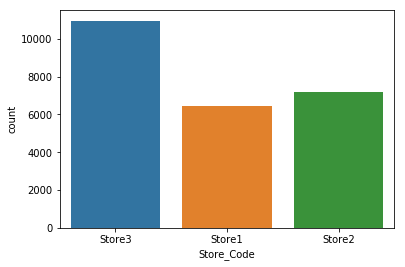

In [8]:
c1 = sns.countplot(secondary_sales['Store_Code'])

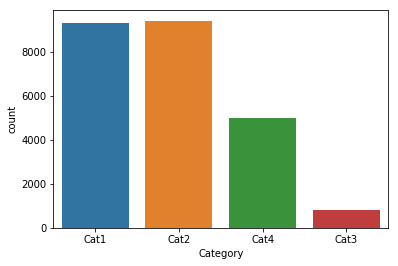

In [9]:
c1 = sns.countplot(secondary_sales['Category'])

# ANALYSIS ON STORE BASIS ON SECONDARY SALE

In [20]:
def resample_store_weekly(df,store_code):
    '''
    Parameter: df Dataframe for secondary sales data
            store_code : subset data for that store
            
    This function subset the data from secondary sales for a particular store and then resample it on weekly basis.
    MRP and SP are resample over week with mean and sales_Qty is sum over the week.
    MRP and SP are price for individual SKU_Code.
    
    We also calculate promotions. And replace NAN with 0.
    NAN are created for october 2017 , for which we do not have data in secondary sales.
    '''
    Store =  df['Store_Code'] == store_code
    Store_secondary_sales = df[Store]
    Store_secondary_sales_week = pd.DataFrame()
    Store_secondary_sales_week_sum = Store_secondary_sales[['Sales_Qty']].resample('W').sum()    
    Store_secondary_sales_week_mean = Store_secondary_sales[['MRP','SP']].resample('W').mean()
    Store_secondary_sales_week['MRP'] = Store_secondary_sales_week_mean['MRP']
    Store_secondary_sales_week['SP'] = Store_secondary_sales_week_mean['SP']
    Store_secondary_sales_week['Promotions'] = 1-Store_secondary_sales_week['SP']/Store_secondary_sales_week['MRP']
    Store_secondary_sales_week['Store_Code'] = store_code
    Store_secondary_sales_week['Sales_Qty'] = Store_secondary_sales_week_sum['Sales_Qty']
    #Handling NAN values
    Store_secondary_sales_week.fillna(0,inplace=True)
    Store_secondary_sales_week
    print(Store_secondary_sales_week.head())
    return Store_secondary_sales_week

In [21]:
Store1_secondary_sales_week = resample_store_weekly(secondary_sales,'Store1')

                   MRP          SP  Promotions Store_Code  Sales_Qty
Date                                                                
2016-01-03  958.333333  826.674242    0.137383     Store1         60
2016-01-10  812.976190  721.057143    0.113065     Store1         72
2016-01-17  939.885496  753.539695    0.198264     Store1        125
2016-01-24  865.000000  717.332000    0.170714     Store1         65
2016-01-31  876.785714  751.913393    0.142421     Store1        100


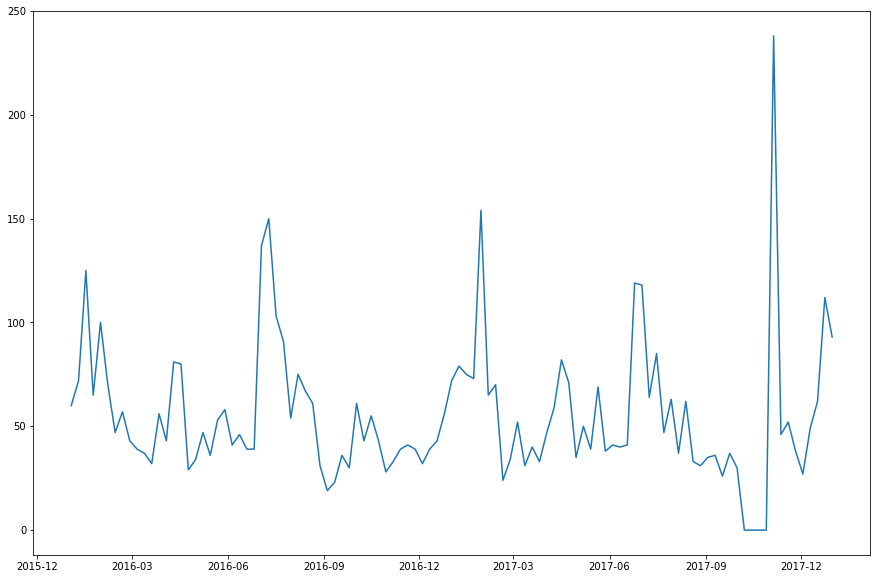

In [23]:
plt.figure(figsize=(15,10))
plt.plot(Store1_secondary_sales_week.index,'Sales_Qty',data=Store1_secondary_sales_week)

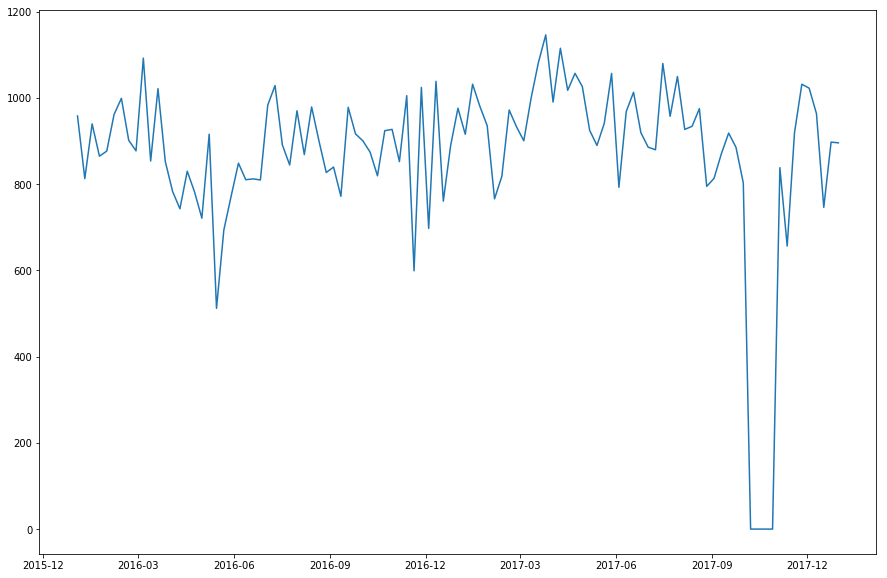

In [24]:
plt.figure(figsize=(15,10))
plt.plot(Store1_secondary_sales_week.index,'MRP',data=Store1_secondary_sales_week)

If you look at above two plot of MRP and Sales_Qty . We can simply say that replacing NAN with 0 is not a good idea . It also does not look the part for the graph . Now we have option for imputation of these 0 values with mean,mode,median.

# Handling missing values

NOTE :Here i can not use the imputation , since it get stock from the primary source and there is chance the store have no stock/no moment of stock from primary to secondary . But looking at the pattern of MRP,SP or promotions ,look like data is missing for that October.

In [26]:
Store1_secondary_sales_week=Store1_secondary_sales_week.replace({'MRP': {0: Store1_secondary_sales_week['MRP'].mean()}}) 
Store1_secondary_sales_week=Store1_secondary_sales_week.replace({'SP': {0: Store1_secondary_sales_week['SP'].mean()}})
Store1_secondary_sales_week=Store1_secondary_sales_week.replace({'Sales_Qty': {0: Store1_secondary_sales_week['Sales_Qty'].mean()}}) 
Store1_secondary_sales_week['Promotions'] = 1-Store1_secondary_sales_week['SP']/Store1_secondary_sales_week['MRP']

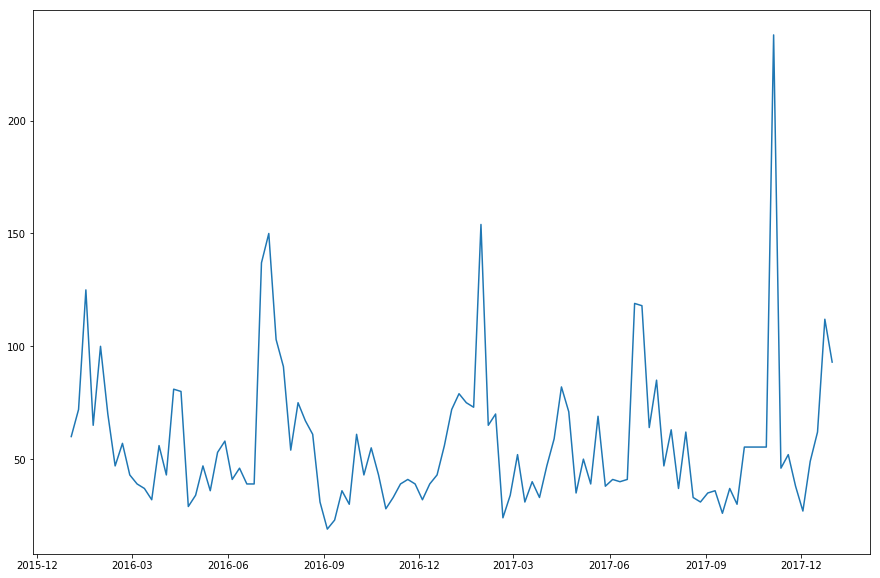

In [27]:
plt.figure(figsize=(15,10))
plt.plot(Store1_secondary_sales_week.index,'Sales_Qty',data=Store1_secondary_sales_week)

I tested all 3 mode for imputation data : mean ,median and mode. 
There was no so much significant difference .
Default i start with mean for imputation .

# Techniques for outlier detection

In [55]:
Store1_secondary_sales_week.head()

,MRP,SP,Promotions,Store_Code,Sales_Qty
Date,,,,,
2016-01-03,958.333333,826.674242,0.137383,Store1,60.0
2016-01-10,812.976190,721.057143,0.113065,Store1,72.0
2016-01-17,939.885496,753.539695,0.198264,Store1,125.0
2016-01-24,865.000000,717.332000,0.170714,Store1,65.0
2016-01-31,876.785714,751.913393,0.142421,Store1,100.0


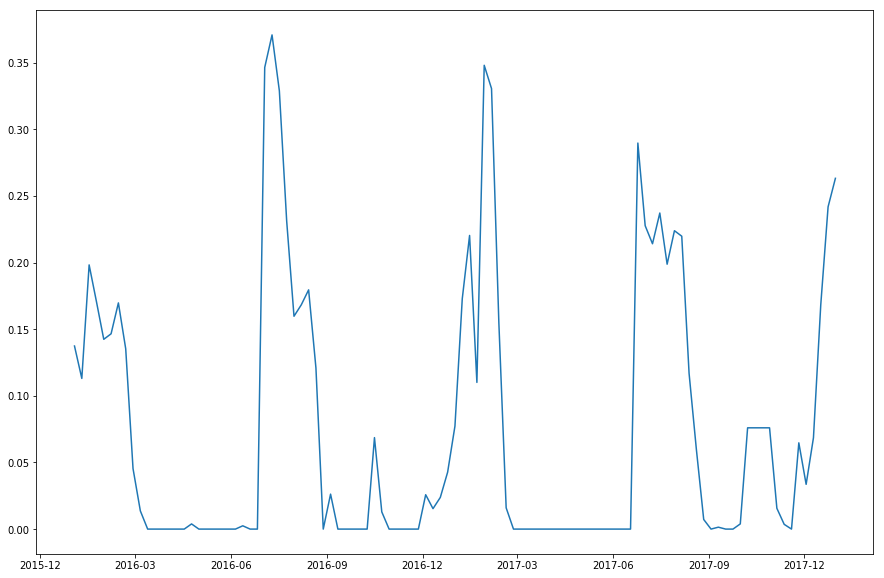

In [57]:
plt.figure(figsize=(15,10))
plt.plot(Store1_secondary_sales_week.index,'Promotions',data=Store1_secondary_sales_week)

Now we can In October 2016 there is also some hike in promotions , similar pattern is also introduce int 2017 October . After doing inputation of missing values

Looking at promotions VS Date and sales_Qty VS Date . It is clear that they are highly co-related , and promotions has high effect on sales_Qty. 
Even we can see the linear trend between Sales_Qty and promotions.

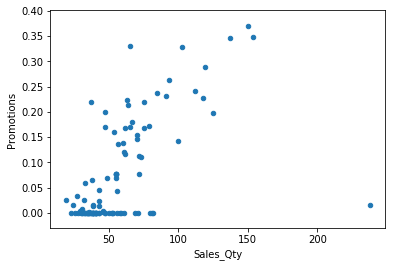

In [58]:
Store1_secondary_sales_week.plot.scatter('Sales_Qty','Promotions')

In [97]:
Store1_secondary_sales_week.head()

,MRP,SP,Promotions,Store_Code,Sales_Qty
Date,,,,,
2016-01-03,958.333333,826.674242,0.137383,Store1,60.000000
2016-01-10,812.976190,721.057143,0.113065,Store1,72.000000
2016-01-17,939.885496,753.539695,0.198264,Store1,53.134242
2016-01-24,865.000000,717.332000,0.170714,Store1,65.000000
2016-01-31,876.785714,751.913393,0.142421,Store1,100.000000


In [95]:
def remove_outlier(df,column,outlier_options='mean',threshold = 3):
    '''
    Function paramter : df Dataframe for secondary sales
                column : on which outlier detection analysis is performed
                outlier_option : This is the outlier treatment options
                    1.mean (default)
                    2.median
                    3.mode
                threshold : outlier detection limit (default 3)
                    
                    Z-score gives the variation of each data point and how much far it lies from the mean
                    Threshold is selected as 3 by default
    '''

    Store_secondary_sales_week_nooutlier = pd.DataFrame()
    df['Z-score'] = np.abs(stats.zscore(df[column]))
    Z =  df['Z-score'] < threshold
    if outlier_options is None:
        df.loc[df['Z-score'] > threshold, column] = df[column].mean()
    if outlier_options == 'mean':
        df.loc[df['Z-score'] > threshold, column] = df[column].mean()
    if outlier_options == 'median':
        df.loc[df['Z-score'] > threshold, column] = df[column].median()
    if outlier_options is 'mode':
        df.loc[df['Z-score'] > threshold, column] = df[column].mode()[0]
    print(Z.value_counts())
    print("False count shows the number of outliers")
    print("Imputing Outlier with ",outlier_options)
    df.drop(columns=['Z-score'],axis=1,inplace=True)
    #print(Store_secondary_sales_week_nooutlier)
    return df

In [96]:
Store1_secondary_sales_week_nooutlier = remove_outlier(Store1_secondary_sales_week,'Sales_Qty')

True    105
Name: Z-score, dtype: int64
False count shows the number of outliers
Imputing Outlier with  mean


In [98]:
Store1_secondary_sales_week_nooutlier = remove_outlier(Store1_secondary_sales_week_nooutlier,'Promotions')

True    105
Name: Z-score, dtype: int64
False count shows the number of outliers
Imputing Outlier with  mean


In [99]:
Store1_secondary_sales_week_nooutlier.reset_index(inplace=True)
Store1_secondary_sales_week_nooutlier.head()

,Date,MRP,SP,Promotions,Store_Code,Sales_Qty
0,2016-01-03,958.333333,826.674242,0.137383,Store1,60.000000
1,2016-01-10,812.976190,721.057143,0.113065,Store1,72.000000
2,2016-01-17,939.885496,753.539695,0.198264,Store1,53.134242
3,2016-01-24,865.000000,717.332000,0.170714,Store1,65.000000
4,2016-01-31,876.785714,751.913393,0.142421,Store1,100.000000


# ANALYSIS ON PRIMARY SALES ON STORE

In [63]:
def primary_feature(df,store_code):
    Store = df['Store_Code'] == store_code
    Store_primary_sales = df[Store]
    Store_primary_sales.drop(columns=['SKU_Code','Category'],axis=1,inplace=True)
    Store_primary_sales_week = Store_primary_sales.resample('W').sum()
    print(Store_primary_sales_week.head())
    return Store_primary_sales_week

In [64]:
Store1_primary_sales_week = primary_feature(primary_sales,'Store1')

            Qty
Date           
2015-12-13   81
2015-12-20  346
2015-12-27    0
2016-01-03  130
2016-01-10    0


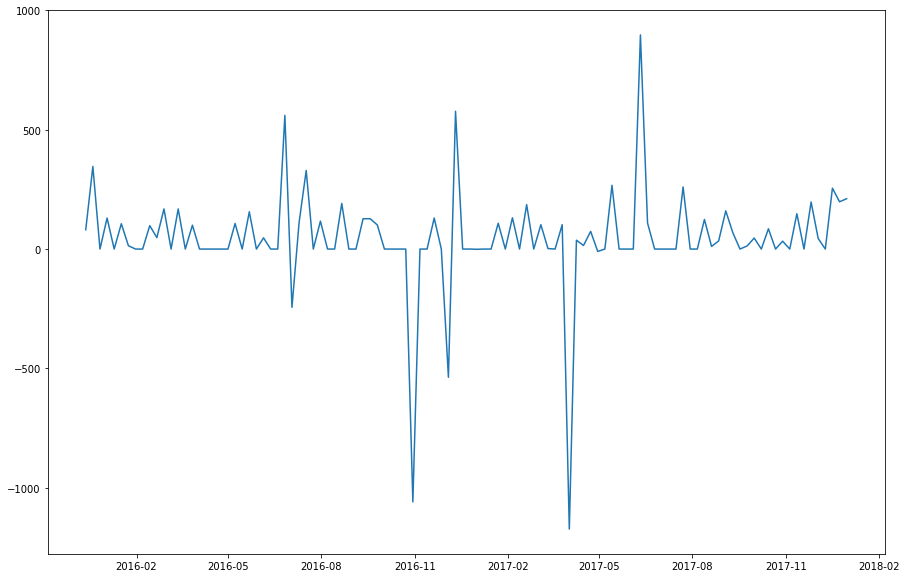

In [65]:
plt.figure(figsize=(15,10))
plt.plot(Store1_primary_sales_week.index,'Qty',data=Store1_primary_sales_week)

In [66]:
Store1_primary_sales_week.reset_index(inplace=True)
Store1_primary_sales_week.head()

,Date,Qty
0,2015-12-13,81
1,2015-12-20,346
2,2015-12-27,0
3,2016-01-03,130
4,2016-01-10,0


Combine primary sales and secondary sales data

Here i am mergeing the two primary and secondary sales frame on the basis of Date as reference.
Obervations: 
1.For 2015 in secondary_sales there is no data , so this Qty is already delivered to respective store . And sales begins after that only.

In [67]:
Store1_primary_secondary = pd.merge(Store1_primary_sales_week,Store1_secondary_sales_week_nooutlier,how='left',on=['Date'])
Store1_primary_secondary = Store1_primary_secondary.replace(np.nan,'0',regex=True)
Store1_primary_secondary['Store_Code'] = 'Store1'
Store1_primary_secondary.head()


,Date,Qty,MRP,SP,Promotions,Store_Code,Sales_Qty
0,2015-12-13,81,0,0,0,Store1,0
1,2015-12-20,346,0,0,0,Store1,0
2,2015-12-27,0,0,0,0,Store1,0
3,2016-01-03,130,958.333,826.674,0.137383,Store1,60
4,2016-01-10,0,812.976,721.057,0.113065,Store1,72


In [68]:
Store1_primary_secondary.dtypes

Date          datetime64[ns]
Qty                    int64
MRP                   object
SP                    object
Promotions            object
Store_Code            object
Sales_Qty             object
dtype: object

Note convert all to int types

In [69]:
Store1_primary_secondary[['Sales_Qty','MRP','SP']] = Store1_primary_secondary[['Sales_Qty','MRP','SP']].astype(int)
Store1_primary_secondary['Promotions'] = 1 - Store1_primary_secondary['SP']/Store1_primary_secondary['MRP']
Store1_primary_secondary.dtypes

Date          datetime64[ns]
Qty                    int64
MRP                    int32
SP                     int32
Promotions           float64
Store_Code            object
Sales_Qty              int32
dtype: object

# 4.Closing Inventory calculations for Store1

Estimation for closing inventory :  
We do not have data for secondary sales for December 2015 , for those weeks data is fill with zeros.  


In [70]:
def closing_inventory(df):
    '''
    Function calculates closing inventory at weekly level
    
    '''
    close_inventory = []
    for i in range(len(df)):
    
        if i == 0:
            close_inventory.append(df.loc[:i,'Qty'][0])
            #print(t1[0])
        else:
            last = int(close_inventory[i-1])
            a = int(list(df.loc[i:i,'Sales_Qty'])[0])
            b = int(list(df.loc[i:i,'Qty'])[0])
        
            result = last - a + b
            #print(result)
            close_inventory.append(result)
    return close_inventory

In [71]:
Store1_primary_secondary['closing-inventory'] = closing_inventory(Store1_primary_secondary)

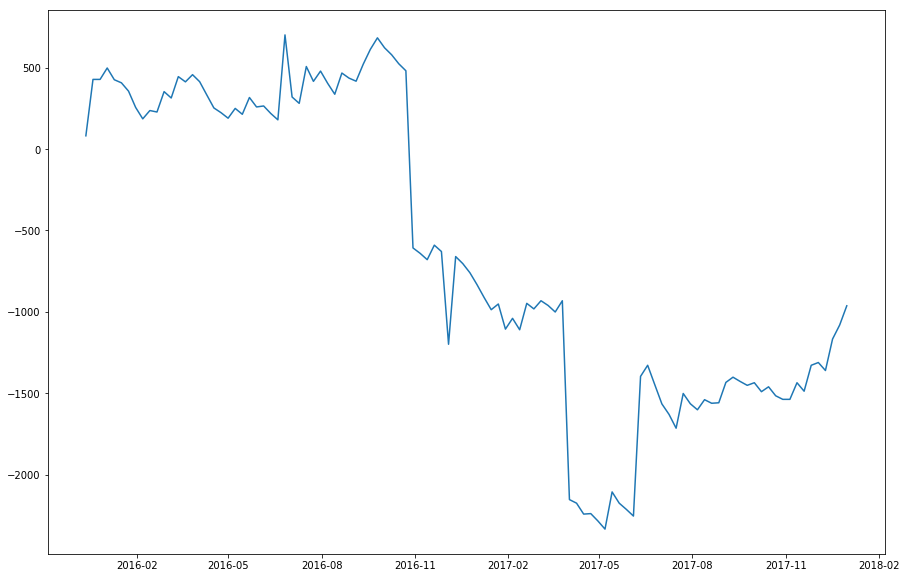

In [72]:
plt.figure(figsize=(15,10))
plt.plot('Date','closing-inventory',data=Store1_primary_secondary)

This graph looks shocking to me . I am not able to understand the reason for this much negativity .

In [73]:
#This is the data at weekly level for Store1
Store1_primary_secondary

,Date,Qty,MRP,SP,Promotions,Store_Code,Sales_Qty,closing-inventory
0,2015-12-13,81,0,0,NaN,Store1,0,81
1,2015-12-20,346,0,0,NaN,Store1,0,427
2,2015-12-27,0,0,0,NaN,Store1,0,427
3,2016-01-03,130,958,826,0.137787,Store1,60,497
4,2016-01-10,0,812,721,0.112069,Store1,72,425
5,2016-01-17,106,939,753,0.198083,Store1,125,406
6,2016-01-24,14,865,717,0.171098,Store1,65,355
7,2016-01-31,0,876,751,0.142694,Store1,100,255
8,2016-02-07,0,961,820,0.146722,Store1,70,185
9,2016-02-14,98,999,829,0.170170,Store1,47,236


# 5.1 Average out of Stock percentage - secondary sales

In [74]:
def averarge_OOS_store(df,store_code):
    '''
    Calculates average out of stock percentage 
    '''
    
    Average_OOS = []
    Average_OOS_df = pd.DataFrame()
    
    Store = df['Store_Code'] == store_code
    Store_second_sales = df[Store]
    Store_second_sales = Store_second_sales[['Store_Code','SKU_Code']]
    Store_second_sales.reset_index(inplace=True)

    column_1 = Store_second_sales['Date']
    temp = pd.DataFrame({"year": column_1.dt.year,
                  "month": column_1.dt.month,
                  "day": column_1.dt.day
                 })

    Store_second_sales.reset_index(drop=True, inplace=True)
    temp.reset_index(drop=True, inplace=True)
    Store_second_sales = pd.concat([Store_second_sales,temp],axis=1)
    
    Date_list = Store_second_sales['Date'].unique()
    for index in Date_list:
        index = pd.to_datetime(index)
        #print(index)
        year = int(index.strftime("%Y"))
        month = int(index.strftime("%m"))
        day = int(index.strftime("%d"))
        #Select the specfic year
        year_select = Store_second_sales['year'] == year
        Store_second_sales_year = Store_second_sales[year_select]
        #Select specfic month
        month_select = Store_second_sales_year['month'] == month
        Store_second_sales_year_month = Store_second_sales_year[month_select]
        #SKU Code month level
        SKU_code_month_count = len(Store_second_sales_year_month['SKU_Code'].unique())
        #Select specfic day
        day_select = Store_second_sales_year_month['day'] == day
        Store_second_sales_year_month_day = Store_second_sales_year_month[day_select]
        #SKU Code day count
        SKU_code_day_count = len(Store_second_sales_year_month_day['SKU_Code'].unique())
        Average_OOS.append(1-SKU_code_day_count/SKU_code_month_count)
    
    Average_OOS_df['Date'] = Date_list
    Average_OOS_df['Average_OOS'] = Average_OOS
    print(Average_OOS_df.head())
    return Average_OOS_df

In [75]:
Store1_second_sales_OOS = averarge_OOS_store(secondary_sales,'Store1')

        Date  Average_OOS
0 2016-01-01     0.959375
1 2016-01-02     0.943750
2 2016-01-03     0.900000
3 2016-01-04     0.987500
4 2016-01-05     0.987500


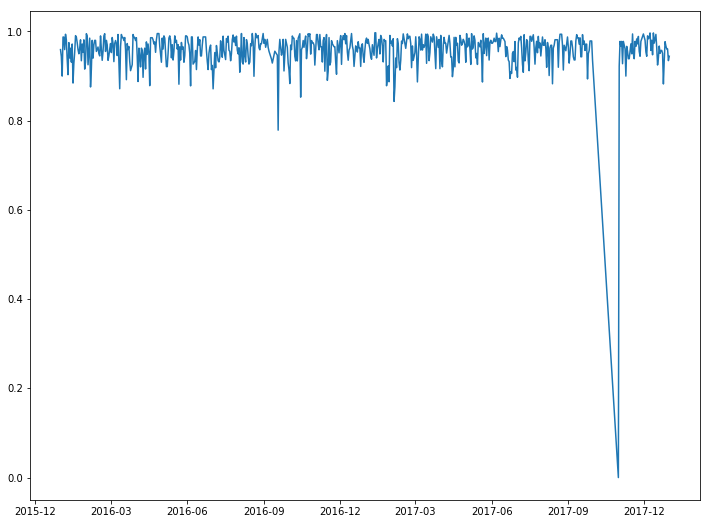

In [76]:
plt.figure(figsize=(12,9))
plt.plot('Date','Average_OOS',data=Store1_second_sales_OOS)

Looking at the plot it is clear that again , 0 are coming as there were no reading in October 2017. So we need to replace 0 with mean,mode or median .


In [77]:
Store1_second_sales_OOS=Store1_second_sales_OOS.replace({'Average_OOS': {0: Store1_second_sales_OOS['Average_OOS'].mean()}}) 

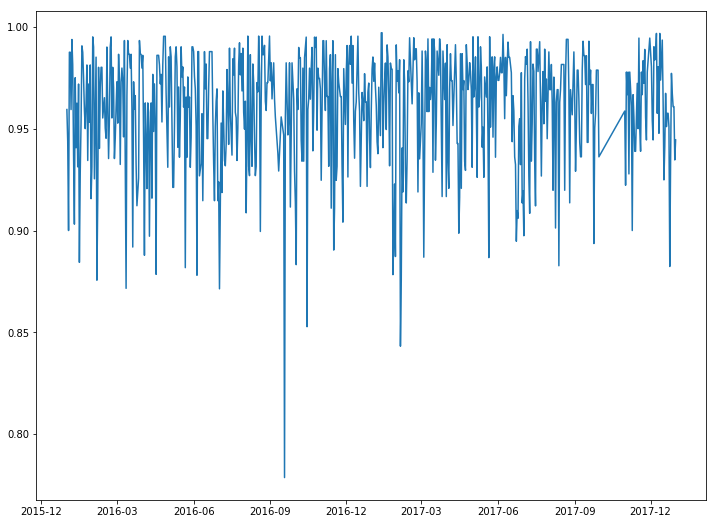

In [78]:
plt.figure(figsize=(12,9))
plt.plot('Date','Average_OOS',data=Store1_second_sales_OOS)

In [96]:
Store1_second_sales_OOS.head()

,Date,Average_OOS
0,2016-01-01,0.959375
1,2016-01-02,0.943750
2,2016-01-03,0.900000
3,2016-01-04,0.987500
4,2016-01-05,0.987500


# 5.2 Average out of stock - stock invoice

In [79]:
invoice_record.head()

,Store_Code,SKU_Code,Category,SOH
Date,,,,
2016-06-27,Store3,602994,Cat1,1
2016-06-27,Store1,602994,Cat1,1
2016-06-27,Store2,602994,Cat1,1
2016-06-27,Store3,602991,Cat1,2
2016-06-27,Store1,602991,Cat1,2


# 6.Model preperation

In [80]:
Store1_primary_secondary.head()

,Date,Qty,MRP,SP,Promotions,Store_Code,Sales_Qty,closing-inventory
0,2015-12-13,81,0,0,NaN,Store1,0,81
1,2015-12-20,346,0,0,NaN,Store1,0,427
2,2015-12-27,0,0,0,NaN,Store1,0,427
3,2016-01-03,130,958,826,0.137787,Store1,60,497
4,2016-01-10,0,812,721,0.112069,Store1,72,425


In [81]:
Store1_primary_secondary.shape

(108, 8)

In [82]:
#Replace 0 with mean
Store1_primary_secondary=Store1_primary_secondary.replace({'Sales_Qty': {0: Store1_primary_secondary['Sales_Qty'].mean()}}) 

In [83]:
train = Store1_primary_secondary[0:100]
test = Store1_primary_secondary[100:]

In [84]:
test.head()

,Date,Qty,MRP,SP,Promotions,Store_Code,Sales_Qty,closing-inventory
100,2017-11-12,148,656,654,0.003049,Store1,46.0,-1434
101,2017-11-19,0,919,919,0.000000,Store1,52.0,-1486
102,2017-11-26,197,1031,965,0.064016,Store1,38.0,-1327
103,2017-12-03,44,1022,988,0.033268,Store1,27.0,-1310
104,2017-12-10,0,963,897,0.068536,Store1,49.0,-1359


In [85]:
train = train.set_index('Date')
test = test.set_index('Date')


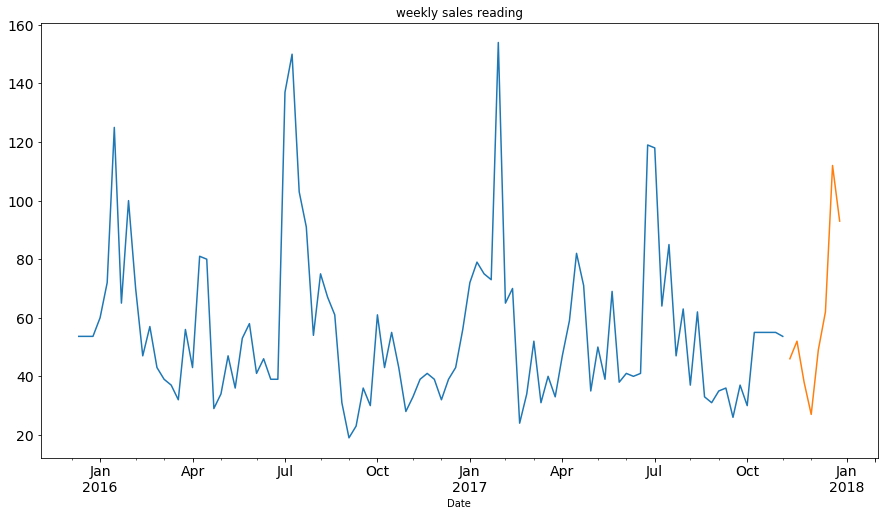

In [86]:
train.Sales_Qty.plot(figsize=(15,8), title= 'weekly sales reading', fontsize=14)
test.Sales_Qty.plot(figsize=(15,8), title= 'weekly sales reading', fontsize=14)
plt.show()

# Holt winter linear method

In [87]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [93]:
y_hat_avg = test.copy()
y_hat_avg['Promotions'] = 1- y_hat_avg['SP']/y_hat_avg['MRP']
y_hat_avg.dtypes

Qty                    int64
MRP                    int32
SP                     int32
Promotions           float64
Store_Code            object
Sales_Qty            float64
closing-inventory      int64
dtype: object

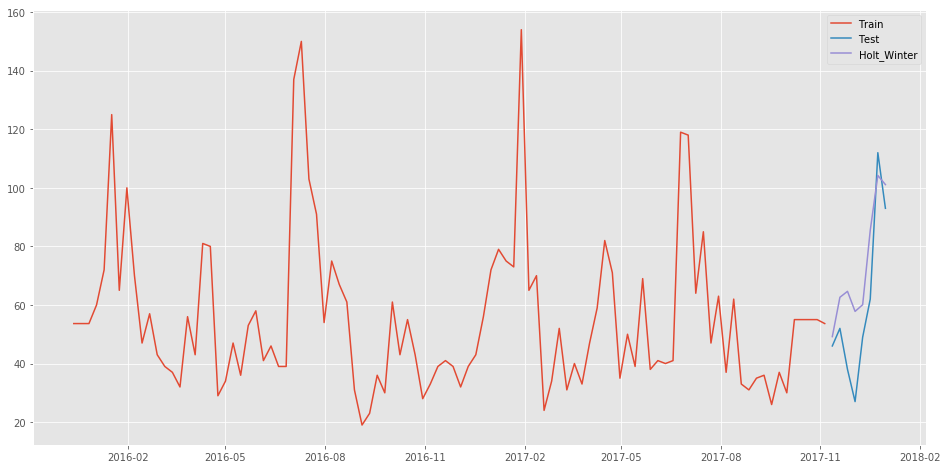

In [141]:
fit1 = ExponentialSmoothing(np.asarray(train['Sales_Qty']) ,seasonal_periods=7 ,trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Sales_Qty'], label='Train')
plt.plot(test['Sales_Qty'], label='Test')
y_hat_avg['Holt_Winter'] = y_hat_avg['Holt_Winter'] + y_hat_avg['Promotions']*200
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

# 2.ML Approach

In [97]:
column_1 = Store1_primary_secondary['Date']

temp = pd.DataFrame({"year": column_1.dt.year,
              "month": column_1.dt.month,
              "day": column_1.dt.day,
              "dayofyear": column_1.dt.dayofyear,
              "week": column_1.dt.week
             })

#secondary_sales_week.reset_index(drop=True, inplace=True)
temp.reset_index(drop=True, inplace=True)
Store1_primary_secondary = pd.concat([Store1_primary_secondary,temp],axis=1)

In [100]:
Store1_primary_secondary.fillna(0,inplace=True)
Store1_primary_secondary.head()

,Date,Qty,MRP,SP,Promotions,Store_Code,Sales_Qty,closing-inventory,year,month,day,dayofyear,week
0,2015-12-13,81,0,0,0.000000,Store1,53.648148,81,2015,12,13,347,50
1,2015-12-20,346,0,0,0.000000,Store1,53.648148,427,2015,12,20,354,51
2,2015-12-27,0,0,0,0.000000,Store1,53.648148,427,2015,12,27,361,52
3,2016-01-03,130,958,826,0.137787,Store1,60.000000,497,2016,1,3,3,53
4,2016-01-10,0,812,721,0.112069,Store1,72.000000,425,2016,1,10,10,1


The first step for the ML approach is to create the feature that we will predict. In our example we don't predict the number of visits but the difference between two days. The tips to create few features is to take the difference between two days and to do a lag. Here we will take a lag of "diff" seven times. If you have a weekly pattern it is an interesting choice. Here we have few data (2 months so 30 values) and it is a contraint. I done some test and the number 7 is a good choice (weekly pattern?).

In [102]:
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [126]:
def lag_func(data,lag):
    lag = lag
    X = lagmat(data["diff"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

def diff_creation(data):
    data["diff"] = 0
    data.ix[1:, "diff"] = (data.iloc[1:,6 ].as_matrix() - data.iloc[:len(data)-1, 6].as_matrix())
    return data

df_count = diff_creation(Store1_primary_secondary)

# Creation of 7 features with "diff"
lag = 7
lagged = lag_func(df_count,lag)

In [127]:
del lagged['Store_Code']

In [128]:
lagged

,Date,Qty,MRP,SP,Promotions,Sales_Qty,closing-inventory,year,month,day,dayofyear,week,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2015-12-13,81,0,0,0.000000,53.648148,81,2015,12,13,347,50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-12-20,346,0,0,0.000000,53.648148,427,2015,12,20,354,51,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2015-12-27,0,0,0,0.000000,53.648148,427,2015,12,27,361,52,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2016-01-03,130,958,826,0.137787,60.000000,497,2016,1,3,3,53,6.351852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2016-01-10,0,812,721,0.112069,72.000000,425,2016,1,10,10,1,12.000000,6.351852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2016-01-17,106,939,753,0.198083,125.000000,406,2016,1,17,17,2,53.000000,12.000000,6.351852,0.000000,0.000000,0.000000,0.000000,0.000000
6,2016-01-24,14,865,717,0.171098,65.000000,355,2016,1,24,24,3,-60.000000,53.000000,12.000000,6.351852,0.000000,0.000000,0.000000,0.000000
7,2016-01-31,0,876,751,0.142694,100.000000,255,2016,1,31,31,4,35.000000,-60.000000,53.000000,12.000000,6.351852,0.000000,0.000000,0.000000
8,2016-02-07,0,961,820,0.146722,70.000000,185,2016,2,7,38,5,-30.000000,35.000000,-60.000000,53.000000,12.000000,6.351852,0.000000,0.000000
9,2016-02-14,98,999,829,0.170170,47.000000,236,2016,2,14,45,6,-23.000000,-30.000000,35.000000,-60.000000,53.000000,12.000000,6.351852,0.000000


In [129]:
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1,lag+1)] + ['week'] + ['day']
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]["diff"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

In [ ]:
x_

In [138]:
# Linear Model
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    # Modelisation with all product
    model0.fit(x_tr, y_tr)

    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts.as_matrix(), model0.predict(x_ts))
    mae = mean_absolute_error(y_ts.as_matrix(), model0.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 70% of the data to train:", mae)
    print ("-----------------------------------------------")

    # Model with all data
    model1.fit(xt, yt) 
    
    return model1, prediction, model0

#model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
model1 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.001)

clr, prediction, clr0  = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)

-----------------------------------------------
mae with 70% of the data to train: 17.16630663949399
-----------------------------------------------


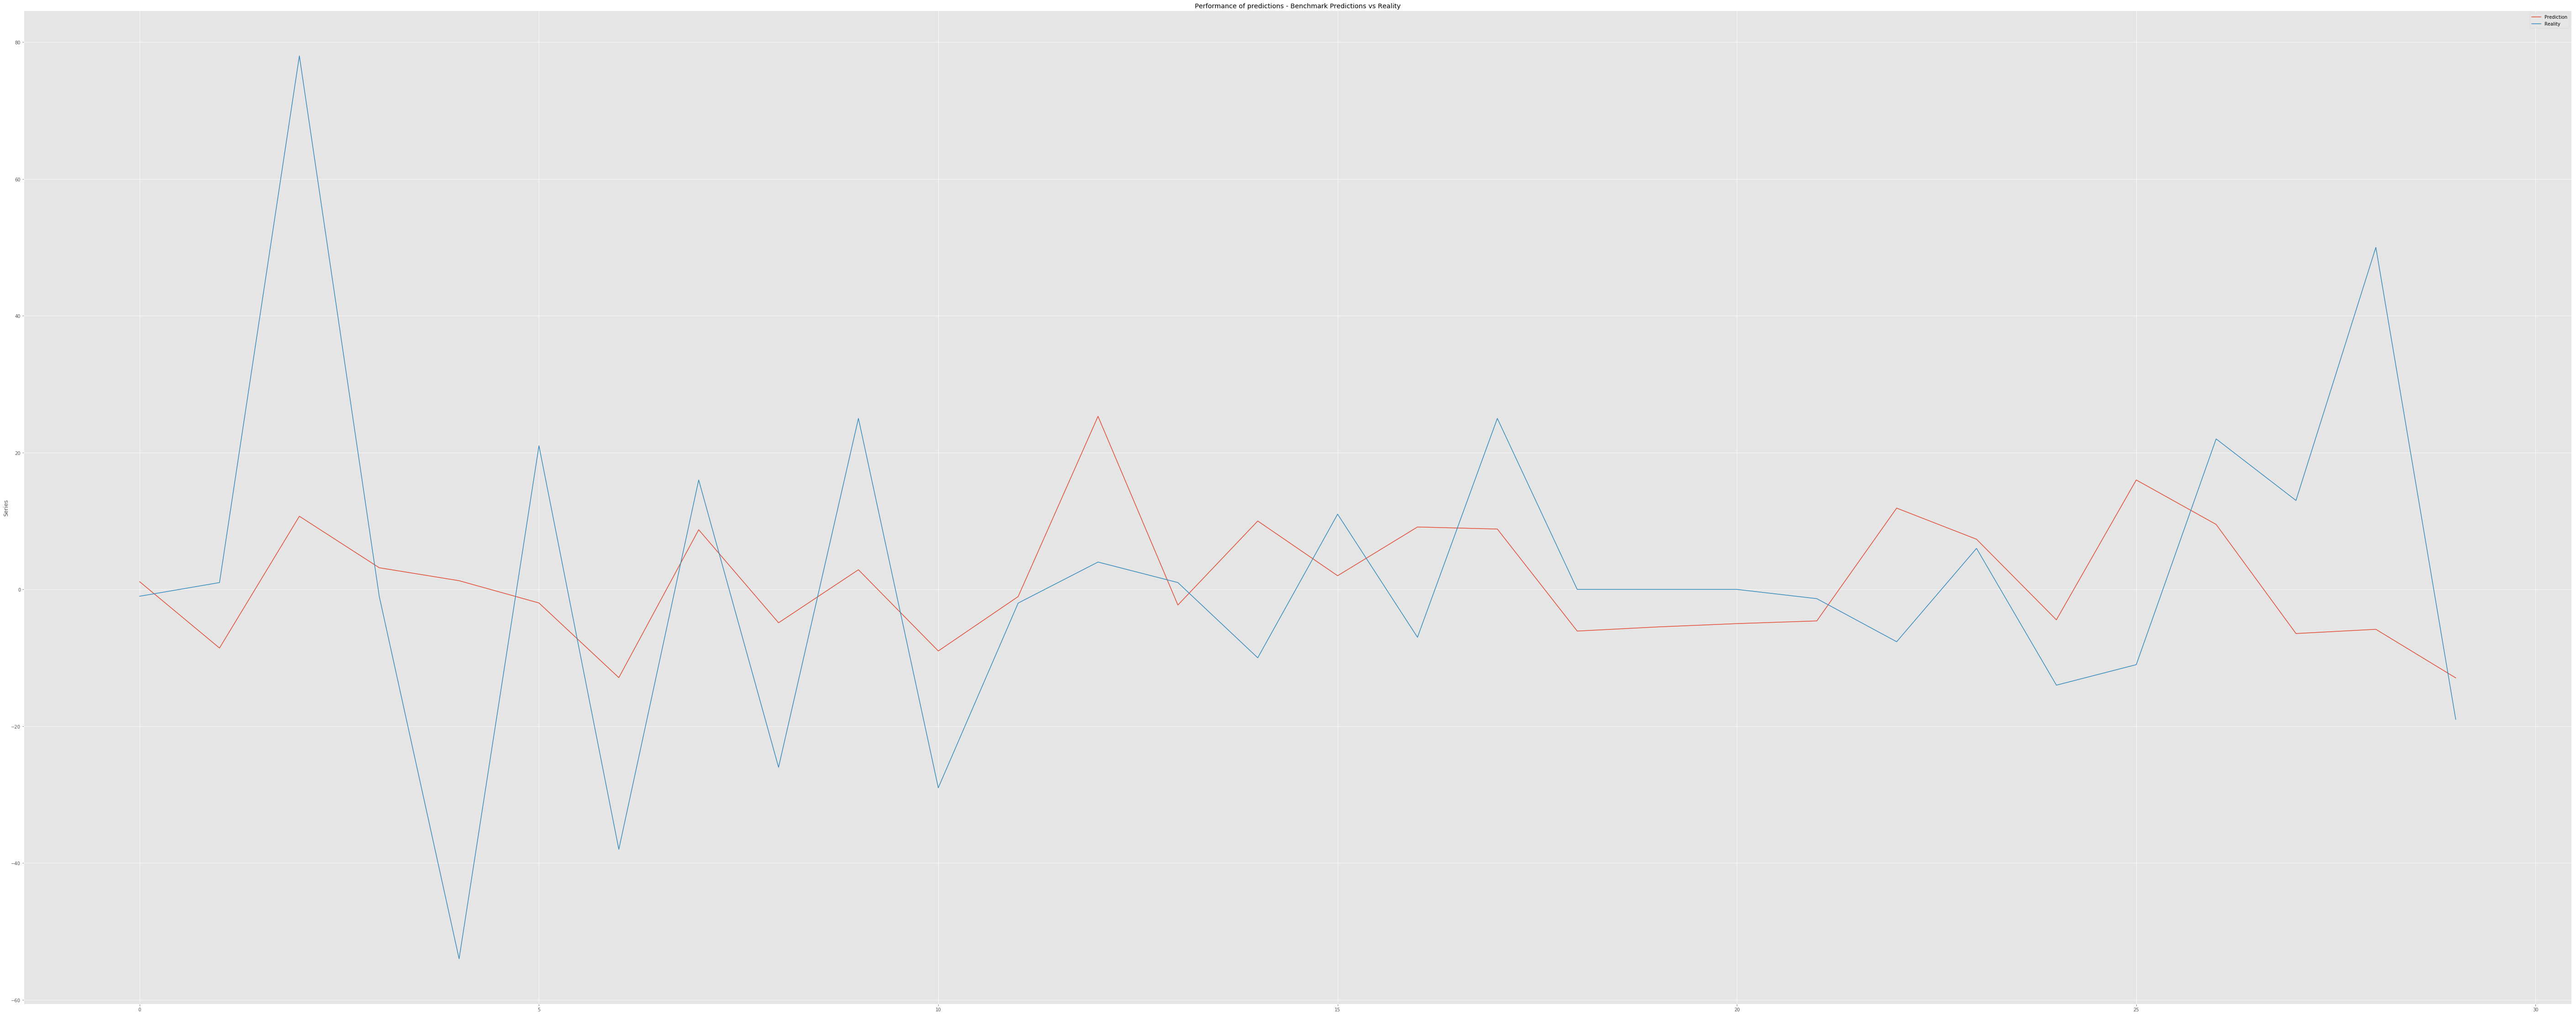

In [139]:
# Performance 1
plt.figure(figsize=(100, 40))
line_up, = plt.plot(prediction,label='Prediction')
line_down, = plt.plot(np.array(y_test),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()